In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *
from fastai.vision import models

In [4]:
from utils import *

In [5]:
DATA = Path('data')
AUDIO = DATA/'freesound/audio_22050_trimmed'
CSV = DATA/'freesound/audio_44KHz/train_with_lens.csv'
TEST_CSV = DATA/'freesound/audio_44KHz/test_with_lens.csv'

In [6]:
df = pd.read_csv(CSV)
if df['fname'].iloc[0].endswith('.wav'):
    df['fname'] = df['fname'].str[:-4]
    df.drop(['manually_verified'], axis=1, inplace=True)

test_df = pd.read_csv(TEST_CSV)

In [7]:
n_fft = 512
n_hop = 256
n_mels = 128
sample_rate = 22050
top_db = 50.0
ref = 1.0

bs = 8

In [8]:
tfms = get_transforms(min_len=n_fft)
batch_tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                            n_mels=n_mels, sample_rate=sample_rate)

In [14]:
test_data = AudioItemList.from_df(test_df, path=AUDIO, 
                                  folder='test', suffix='.wav')
data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, 
                       tfms=batch_tfms, length_col=2))

len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(7579, 1894, 9400)

In [15]:
xs, ys = data.one_batch()
xs.shape, ys.shape, xs.min(), xs.max()

(torch.Size([8, 1, 128, 1717]), torch.Size([8]), tensor(0.1522), tensor(1.))

### ResNet18

In [17]:
model_name = '512_256_resnet18_v1'

learn = create_cnn(data, models.resnet18, metrics=[accuracy, mapk])

learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy,mapk
1,2.882709,2.630487,0.331045,0.443418
2,2.599620,2.335444,0.395459,0.500704
3,2.245805,2.049010,0.475185,0.574798
4,2.094090,2.070032,0.518479,0.613516
5,1.847470,1.713719,0.556494,0.651003
6,1.755008,1.641383,0.580781,0.670979
7,1.715915,1.661898,0.582365,0.676259
8,1.704324,1.678704,0.580781,0.673443


### ResNet34

In [18]:
model_name = '512_256_resnet34_v1'

learn = create_cnn(data, models.resnet34, metrics=[accuracy, mapk])

learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy,mapk
1,2.997167,2.430241,0.359029,0.464713
2,2.461090,2.083838,0.449842,0.553502
3,2.233608,1.923996,0.499472,0.600757
4,2.041663,1.778538,0.565470,0.658483
5,1.821542,1.574854,0.604541,0.689810
6,1.682874,1.787907,0.579197,0.676171
7,1.649772,1.492633,0.631996,0.713657
8,1.570113,1.438673,0.636220,0.720433


### Test new transforms

In [38]:
trn_batch_tfms = get_frequency_batch_transforms(n_fft=n_fft, 
                                                n_hop=n_hop,
                                                n_mels=n_mels, 
                                                sample_rate=sample_rate, 
                                                rand_hop_pct=0.15)

val_batch_tfms = get_frequency_batch_transforms(n_fft=n_fft, 
                                                n_hop=n_hop,
                                                n_mels=n_mels, 
                                                sample_rate=sample_rate)

In [39]:
data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, length_col=2))

data.train_dl.add_tfm(trn_batch_tfms[0])
data.valid_dl.add_tfm(val_batch_tfms[0])
data.test_dl.add_tfm(val_batch_tfms[0])

len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(7579, 1894, 9400)

In [40]:
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([8, 1, 128, 2011]), torch.Size([8]))

In [41]:
model_name = '512_256_resnet34_v2'

learn = create_cnn(data, models.resnet34, metrics=[accuracy, mapk])

learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy,mapk
1,2.930126,2.637983,0.326294,0.426962
2,2.573511,2.206999,0.426610,0.541446
3,2.254979,1.922366,0.520063,0.613428
4,1.917935,1.778279,0.554910,0.646692
5,1.789057,1.644542,0.583421,0.670451
6,1.752057,1.656681,0.597149,0.681010
7,1.589658,1.465417,0.623548,0.704065
8,1.508132,1.477948,0.614572,0.698170


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


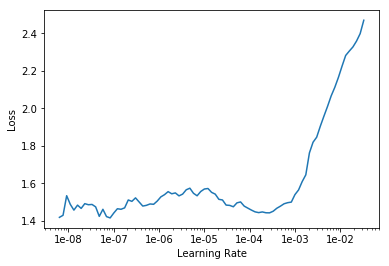

In [42]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1e-1)
learn.recorder.plot()

In [44]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=slice(1e-5,1e-4))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy,mapk
1,1.405780,1.397305,0.637804,0.717177
2,1.418831,1.365900,0.650475,0.727033
3,1.262106,1.235343,0.680570,0.754664
4,1.108992,1.065522,0.730201,0.791007
5,1.003378,0.919856,0.754488,0.812390
6,0.751073,0.864200,0.775079,0.824886
7,0.666431,0.836979,0.779831,0.831486
8,0.592430,0.919472,0.770327,0.824534
